In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from skimage import io
import PIL
import torch

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import torch.nn.functional as F
from IPython.display import display

# PyTorch libraries and modules
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

from timeit import default_timer as timer

In [2]:
test_folder = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/kaggle/kaggle/test/'
train_folder = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/kaggle/kaggle/train/'

train_age_csv = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/train_age.csv'
train_gender_csv = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/train_gender.csv'

resize_value = 128
batch_size = 128
epochs = 6

In [3]:
class XRayTrain(Dataset):
    def __init__(self, csv_file, img_dir, transform = None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(csv_file, nrows = 10702, dtype = {'imageId': str})
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, f"{self.annotations.iloc[index, 0]}.png")
        img = Image.open(img_path)
        img = img.resize((resize_value, resize_value))
        img = Image.fromarray(255 - np.array(img))
        y_label = torch.tensor(int (self.annotations.iloc[index, 1]))

        if self.transform:
            img = self.transform(img)

        return (img, y_label)

In [4]:
# Creating tensors for the images and their labels for gender
train_g_data = XRayTrain(csv_file = train_gender_csv, img_dir = train_folder,
                       transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                        transforms.Resize((resize_value, resize_value)),
                                                        transforms.ToTensor()]))

train_size = int(0.8 * len(train_g_data))
test_size = len(train_g_data) - train_size

train_gender_data, test_gender_data = torch.utils.data.random_split(train_g_data, [train_size, test_size])

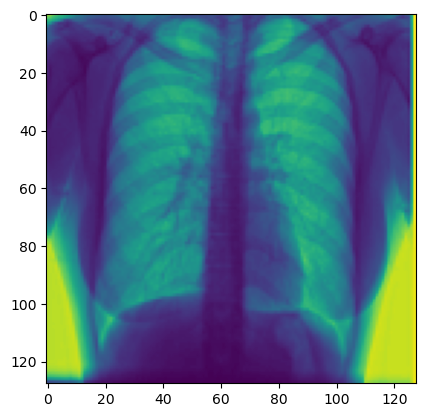

In [5]:
# To check if images are stored correctly
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

for i in range(len(test_gender_data)):
    img, label = test_gender_data[i]
    img = img.permute(1,2,0)
    imshow(img)
    if i == 4:
        break

In [6]:
# loading the data
train_gender_loader = DataLoader(dataset = train_gender_data, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_gender_loader = DataLoader(dataset = test_gender_data, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [7]:
# Creating the Gender Model
class GenderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.drop1 = nn.Dropout(p = 0.4)
        self.fc2 = nn.Linear(1024, 128)
        self.drop2 = nn.Dropout(p = 0.5)
        self.fc3 = nn.Linear(128, 2)

    def forward(self,x):
        x = self.pool1(F.relu(self.batch1((self.conv1(x)))))
        x = self.pool2(F.relu(self.batch2((self.conv2(x)))))
        x = self.pool3(F.relu(self.batch3((self.conv3(x)))))
        x = self.pool4(F.relu(self.batch4((self.conv4(x)))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [8]:
CUDA_LAUNCH_BLOCKING =1
gpus = torch.cuda.device_count()

model1 = GenderModel()
if gpus >= 1:
    print("Let's use", gpus, "GPUs!")
    model = nn.DataParallel(model1, list(range(gpus)))

device = torch.device("cuda")
model.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): GenderModel(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [9]:
def train(): 
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)   
    
    n_samples = 10240
    total_loss = 0
    total_train = 0
    correct_train = 0.0
    
    for i, (img, labels) in enumerate(train_gender_loader):
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        
        #accuracy
        _, predicted = torch.max(output.data, 1)
        predicted = predicted
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        
    losses.append(loss.item())
    train_acy.append(train_accuracy)
    
    return (train_accuracy, loss.item())

In [10]:
def valid(epochs):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i, (img, labels) in enumerate(test_gender_loader):
                img = img.to(device)
                labels = labels.to(device)
                outputs = model(img)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = 100 * correct / total
                
    valid_acy.append(acc)
    
    return acc

In [11]:
classes = ('Female', 'Male')
def predict(img_test_dir):
    model1 = torch.load('/home/doshi.mee/csye7105_project/gender_model_dp.pt')
    img = Image.open(img_test_dir)
    
    with torch.no_grad():
        trans1 = transforms.Compose([transforms.Grayscale(num_output_channels = 1),
                                                        transforms.Resize((resize_value, resize_value)),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean = [0.5], std = [0.5])])
        img_tensor = trans1(img)
        
        single_image_batch = img_tensor.unsqueeze(0)
        outputs = model1(single_image_batch)
        _, predicted = torch.max(outputs.data, 1)
        class_id = predicted[0].item()
        predicted_class = classes[predicted[0].item()]
        
        print("Predicted Class : {}".format(predicted_class))
        display(img.resize((256, 256)))

Training for 6 epochs
Epoch 0, train Loss: 0.559 Training Accuracy 65.55308959233734: Valid Accuracy 74.077533862681
GPU time:  381.81332581001334
Epoch 1, train Loss: 0.455 Training Accuracy 79.41829225557763: Valid Accuracy 83.32554880896777
GPU time:  375.1463996010134
Epoch 2, train Loss: 0.267 Training Accuracy 86.38009578320289: Valid Accuracy 87.85614198972443
GPU time:  375.1133256839821
Epoch 3, train Loss: 0.290 Training Accuracy 87.89860997547015: Valid Accuracy 89.9112564222326
GPU time:  375.305353082018
Epoch 4, train Loss: 0.231 Training Accuracy 90.56185025113889: Valid Accuracy 90.98552078468006
GPU time:  375.7931195429992
Epoch 5, train Loss: 0.233 Training Accuracy 91.75329984814859: Valid Accuracy 92.05978514712751
GPU time:  376.2104765609838
Model successfully saved
Time taken for 6 epochs is 2259.6055966909043 seconds


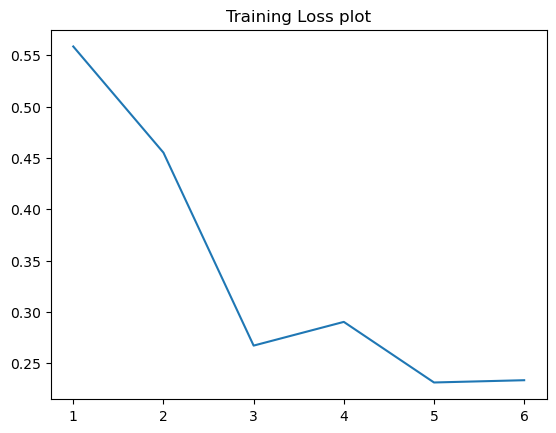

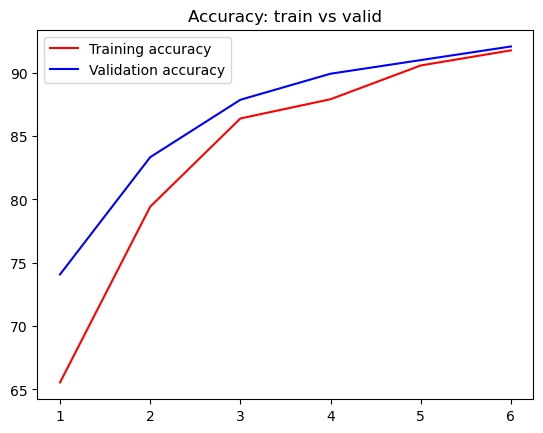

In [12]:
import sys
import argparse

print("Training for {} epochs".format(epochs))

main_time = timer()
losses = []
train_acy = []
valid_acy = []

for epoch in range(epochs):
    start = timer()
    (train_acc, loss_tr) = train()
    valid_acc = valid(epochs)
    
    print('Epoch {}, train Loss: {:.3f}'.format(epoch ,loss_tr), 'Training Accuracy {}:' .format(train_acc), 'Valid Accuracy {}'.format(valid_acc))
    print("GPU time: ", timer() - start)

folder = '/home/doshi.mee/csye7105_project'
torch.save(model, f"{folder}/gender_model_dp.pt")
print("Model successfully saved")
torch.cuda.empty_cache()

print("Time taken for", epochs, "epochs is", timer() - main_time, "seconds")

epoch = range(1, len(losses) + 1)
plt.title("Training Loss plot")
plt.plot(epoch, losses)

plt.figure()
plt.title("Accuracy: train vs valid")
plt.plot(epoch, train_acy, 'red', label = 'Training accuracy')
plt.plot(epoch, valid_acy, 'blue', label = 'Validation accuracy')
plt.legend()
plt.show()

Predicted Class : Male


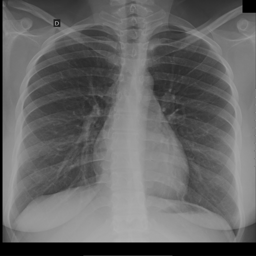

In [13]:
predict(f"{test_folder}000945.png")